# 휴대폰 가격 예측 보고서 (데이터 탐색 파일)

데이터 출처 : https://www.kaggle.com/datasets/sumedh1507/mobile-uncleaned-dataset?resource=download

# 1. Spark세션 불러오기

In [34]:
from pyspark.sql import SparkSession

In [35]:
# 메모리 부족하지 않도록 용량 8g로 설정

MAX_MEMORY = '8g'

In [36]:
spark = SparkSession.builder.appName("MobilePhonePricePredict")\
    .config('spark.driver.memory', MAX_MEMORY)\
    .config('spark.executor.memory', MAX_MEMORY)\
    .getOrCreate()

## 1-1. 데이터 가져오기

In [37]:
import os

cwd = os.getcwd()

data_file_name = 'mobile_dataset.csv'
data_path = os.path.join(cwd, data_file_name)

# 스파크가 파일을 읽을 수 있는 URI 형식으로 변환
file_path = f"file:///{data_path.replace(os.sep, '/')}"

In [38]:
df = spark.read.csv(file_path, inferSchema=True, header=True)

# 데이터프레임 스키마 확인
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Spec Score: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- img: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- sim: string (nullable = true)
 |-- processor: string (nullable = true)
 |-- storage: string (nullable = true)
 |-- battery: string (nullable = true)
 |-- display: string (nullable = true)
 |-- camera: string (nullable = true)
 |-- memoryExternal: string (nullable = true)
 |-- version: string (nullable = true)
 |-- fm: string (nullable = true)



In [39]:
# 데이터프레임 상위 5개 확인
df.show(5)

+-------------------+----------+------+-----+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+-----------+
|               Name|Spec Score|rating|price|                 img|     tag|                 sim|           processor|             storage|             battery|             display|              camera|      memoryExternal|    version|         fm|
+-------------------+----------+------+-----+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+-----------+
|OPPO Reno 14 Pro 5G|        89|  4.65|41990|https://cdn1.smar...|UPCOMING|Dual Sim, 3G, 4G,...|Dimensity 8450, O...|12 GB RAM, 256 GB...|6200 mAh Battery ...|6.83 inches, 1272...|50 MP + 50 MP + 5...|                NULL|Android v15|No FM Radio|
|    OPPO Re

### 데이터프레임 구조를 확인하며 각 컬럼들을 확인해본다.
- Name(str형) : 휴대폰 이름
- Spec Score(int형) : 휴대폰의 종합적인 성능 점수로, 가격에 직접적인 영향을 미칠 것으로 예상
- rating(double형) : 사용자 평점으로, 인기도를 나타내는 지표이다. 가격 예측에 영향을 미칠 것으로 예상
- **price(int형) : 목표 변수**
- img : 이미지 파일명
- tag : 휴대폰의 태그 정보
- sim(str형) : SIM 정보
- processor(str형) : 휴대폰의 프로세서(CPU) 정보로, 성능에 큰 영향을 미친다.
- storage(str형) : 저장 용량 정보로, 가격 예측에 영향을 미칠 것으로 예상
- battery(str형) : 배터리 용량 정보로, 가격 예측에 영향을 미칠 것으로 예상
- display(str형) :  디스플레이 정보로, 화면 크기나 종류가 가격에 영향을 미칠 수 있다.
- camera(str형) : 카메라 스펙 정보로, 가격에 영향을 미칠 수 있다.
- memoryExternal(str형) : 외장 메모리 정보
- version(str형) : 운영체제 버저
- fm(str형) : FM라디오 기능 내장 여부

## 1-2. 결측치 확인

In [40]:
df.count()

1019

In [41]:
from pyspark.sql.functions import col, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----------+------+-----+---+---+---+---------+-------+-------+-------+------+--------------+-------+---+
|Name|Spec Score|rating|price|img|tag|sim|processor|storage|battery|display|camera|memoryExternal|version| fm|
+----+----------+------+-----+---+---+---+---------+-------+-------+-------+------+--------------+-------+---+
|   0|         0|     0|    0|  0|  0|  0|       26|     20|      6|      1|    11|           351|     48|725|
+----+----------+------+-----+---+---+---+---------+-------+-------+-------+------+--------------+-------+---+



#### 총 데이터의 개수는 1019개이다.
- fm이 725개로 결측치가 가장 많고, memoryExternal이 351개의 결측치로 그 뒤를 따른다.
- processor, storage, battery, display, camera, version에도 약간의 결측치가 존재한다.

# 2. EDA(탐색적 데이터 분석)

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Spark DataFrame 데이터를 Pandas DataFrame으로 변환하여 시각화 진행
pandas_df = df.toPandas()

## 2-1. 목표 변수(price)의 분포 확인

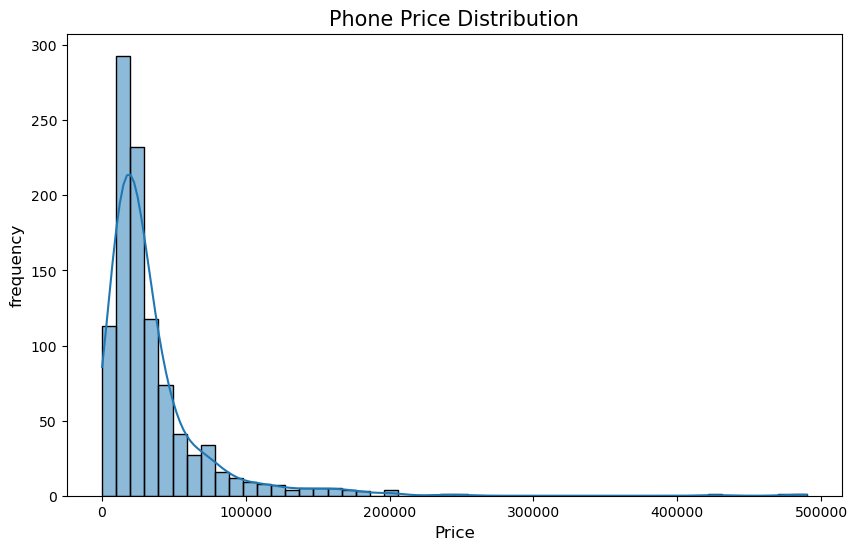

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['price'], bins=50, kde=True)
plt.title('Phone Price Distribution', fontsize=15)   # 휴대폰 가격 분포
plt.xlabel('Price', fontsize=12)   # 가격
plt.ylabel('frequency', fontsize=12)   # 빈도수
plt.show()

## 2-2. 주요 특성과 목표 변수의 관계 확인 (산점도 및 상관계수)

### 가격 예측에 영향을 미칠 것으로 예상되는 변수들로 확인

### 2-2-(1). Spen Score(휴대폰 성능 점수)

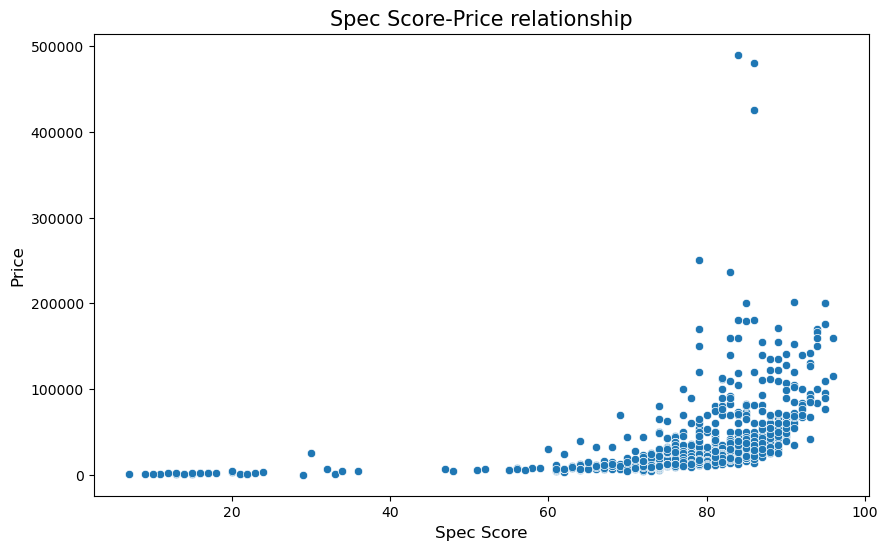

Spec Score와 price의 상관계수: 0.3635


In [45]:
# Spec Score와 price의 관계를 산점도로 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Spec Score', y='price', data=pandas_df)
plt.title('Spec Score-Price relationship', fontsize=15)   # 휴대폰 성능 점수와 가격의 관계
plt.xlabel('Spec Score', fontsize=12)   # 휴대폰 성능 점수
plt.ylabel('Price', fontsize=12)   # 가격
plt.show()

# 두 변수 간의 상관계수(correlation) 계산
correlation = pandas_df[['Spec Score', 'price']].corr().iloc[0, 1]
print(f"Spec Score와 price의 상관계수: {correlation:.4f}")

### 2-2-(2). rating(사용자 평점)

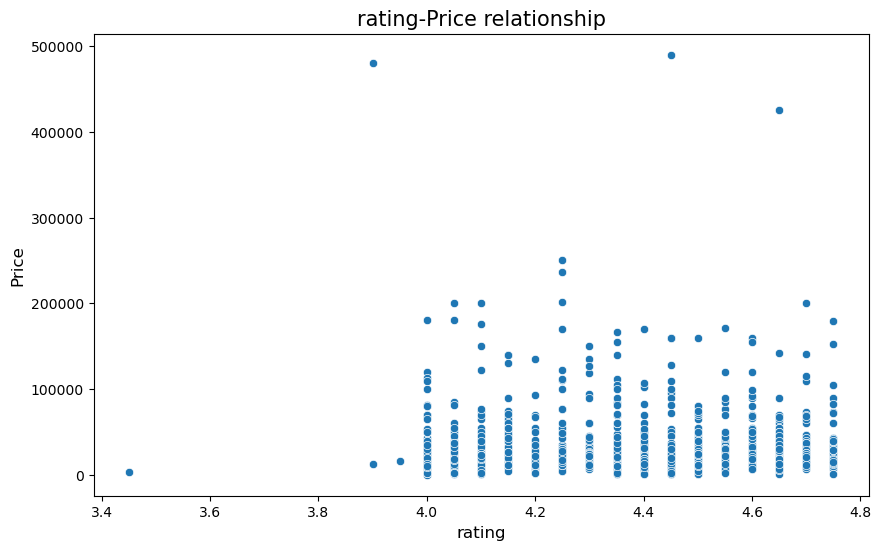

rating와 price의 상관계수: -0.0177


In [46]:
# rating와 price의 관계를 산점도로 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='price', data=pandas_df)
plt.title('rating-Price relationship', fontsize=15)   # 사용자 평점과 가격의 관계
plt.xlabel('rating', fontsize=12)   # 사용자 평점
plt.ylabel('Price', fontsize=12)   # 가격
plt.show()

# 두 변수 간의 상관계수(correlation) 계산
correlation = pandas_df[['rating', 'price']].corr().iloc[0, 1]
print(f"rating와 price의 상관계수: {correlation:.4f}")

### 2-2-(3). processor(휴대폰의 프로세서(CPU) 정보)

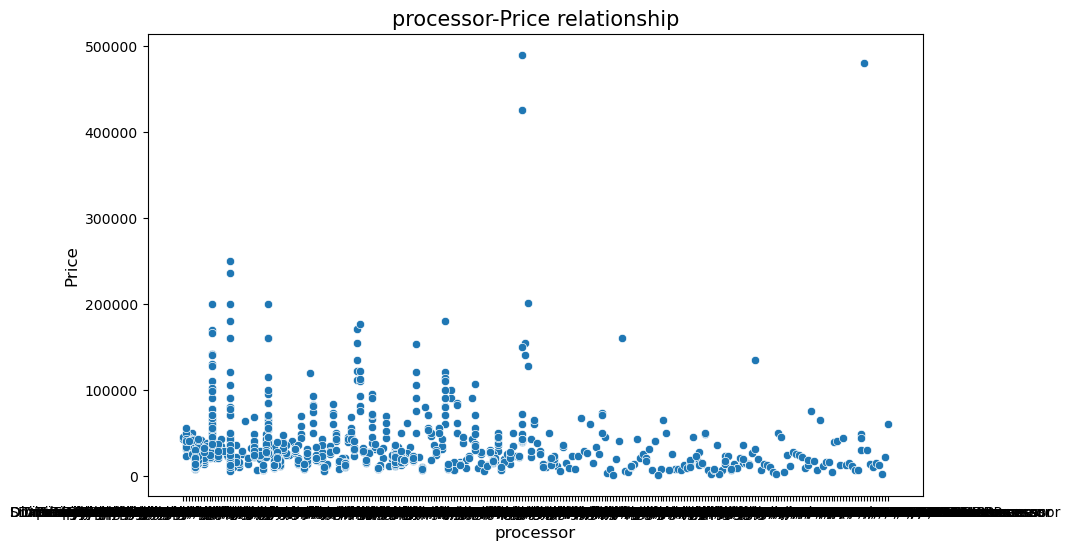

In [47]:
# processor와 price의 관계를 산점도로 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='processor', y='price', data=pandas_df)
plt.title('processor-Price relationship', fontsize=15)   # 프로세서 정보와 가격의 관계
plt.xlabel('processor', fontsize=12)   # 프로세서 정보
plt.ylabel('Price', fontsize=12)   # 가격
plt.show()

# 두 변수 간의 상관계수(correlation) 계산 -> processor 컬럼이 범주형
#correlation = pandas_df[['processor', 'price']].corr().iloc[0, 1]
#print(f"processor와 price의 상관계수: {correlation:.4f}")

### 2-2-(4). storage(저장 용량 정보)

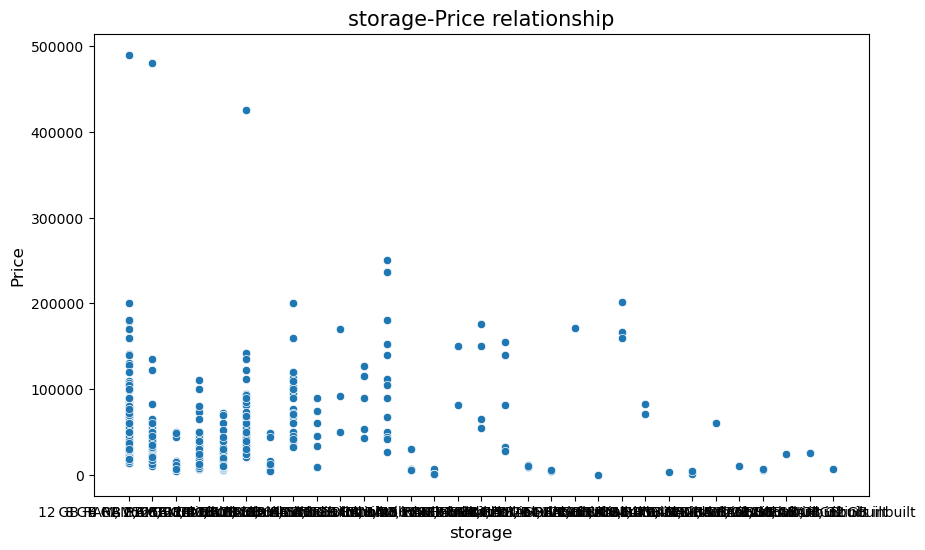

In [48]:
# storage와 price의 관계를 산점도로 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='storage', y='price', data=pandas_df)
plt.title('storage-Price relationship', fontsize=15)   # 저장 용량 정보와 가격의 관계
plt.xlabel('storage', fontsize=12)   # 저장 용량 정보
plt.ylabel('Price', fontsize=12)   # 가격
plt.show()

# 두 변수 간의 상관계수(correlation) 계산 -> storage 컬럼이 범주형
#correlation = pandas_df[['storage', 'price']].corr().iloc[0, 1]
#print(f"storage와 price의 상관계수: {correlation:.4f}")

### 2-2-(5). battery(배터리 용량 정보)

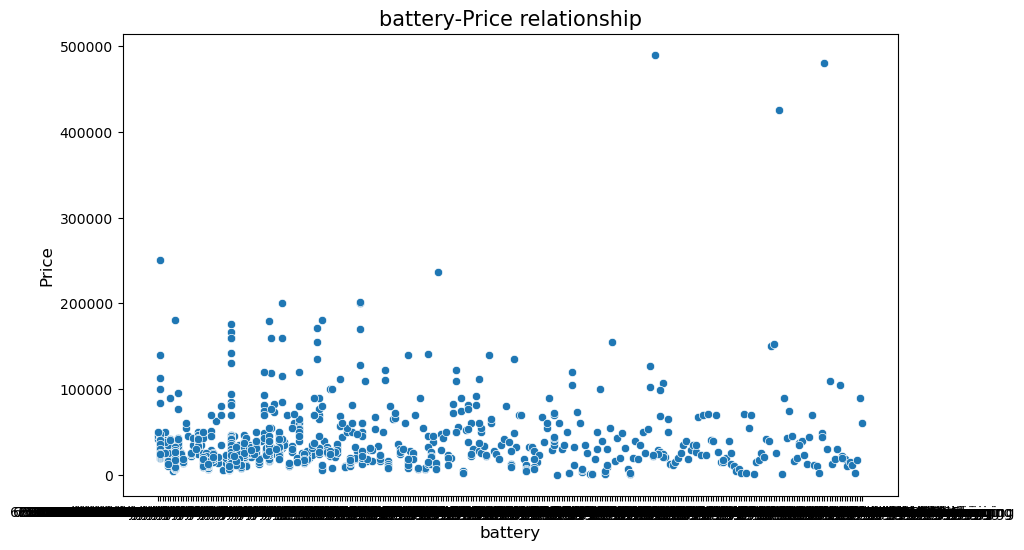

In [49]:
# battery와 price의 관계를 산점도로 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='battery', y='price', data=pandas_df)
plt.title('battery-Price relationship', fontsize=15)   # 저장 용량 정보와 가격의 관계
plt.xlabel('battery', fontsize=12)   # 저장 용량 정보
plt.ylabel('Price', fontsize=12)   # 가격
plt.show()

# 두 변수 간의 상관계수(correlation) 계산 -> battery 컬럼이 범주형
#correlation = pandas_df[['battery', 'price']].corr().iloc[0, 1]
#print(f"battery와 price의 상관계수: {correlation:.4f}")

### 2-2-(6). camera(카메라 스펙 정보)

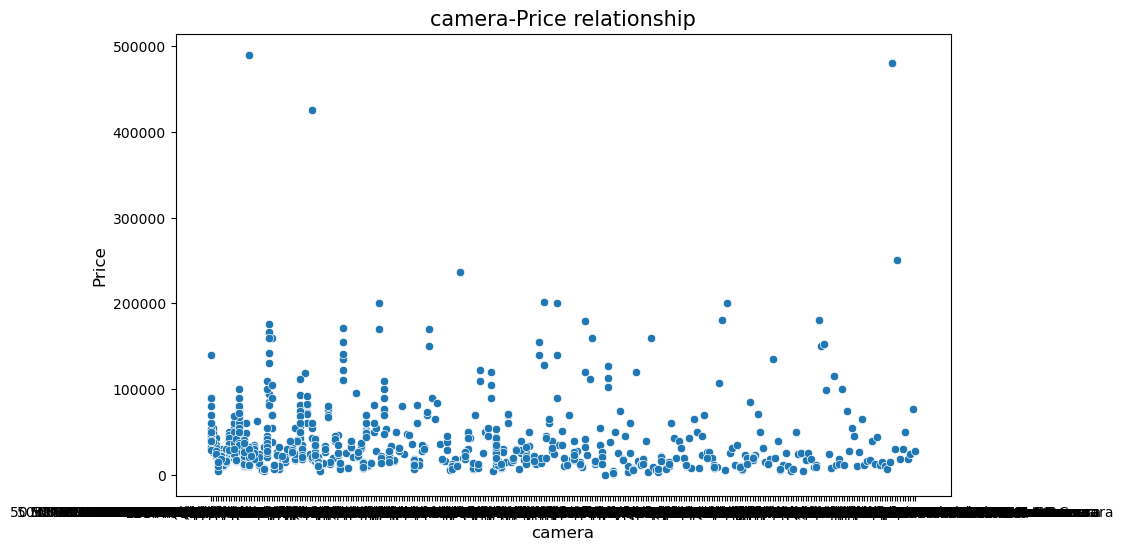

In [50]:
# camera와 price의 관계를 산점도로 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='camera', y='price', data=pandas_df)
plt.title('camera-Price relationship', fontsize=15)   # 저장 용량 정보와 가격의 관계
plt.xlabel('camera', fontsize=12)   # 저장 용량 정보
plt.ylabel('Price', fontsize=12)   # 가격
plt.show()

# 두 변수 간의 상관계수(correlation) 계산 -> camera 컬럼이 범주형
#correlation = pandas_df[['camera', 'price']].corr().iloc[0, 1]
#print(f"camera와 price의 상관계수: {correlation:.4f}")

### 2-3. EDA 분석

- Spec Score가 높을수록 price도 상승하는 양의 상관관계가 나타난다.
- rating은 4.0이상에서는 분포에 관계 없이 price가 골고루 분포해있는 그림이나, 음의 상관관계이다.
- processor, storage, battery, camera는 컬럼에 고유한 값이 너무 많고, price가 골고루 분포해있다.

In [51]:
# 데이터 탐색 노트북 종료 (스파크 종료)
spark.stop()